In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.formula.api as smf
import scikit_posthocs as sp
import seaborn as sns
import itertools
from matplotlib.backends.backend_pdf import PdfPages


sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
plt.rc("font", size=14)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import BoundaryNorm, ListedColormap

In [3]:
columns = ['noun', 'adj', 'propn', 'adv', 'intj', 'cconj', 'sconj', 'adp', 'det', 'num', 'punct', 'symbol', 'pron', 'abbr', 'nominals', 'TTR', 'avg_word_len', 'avr_sent_len', 'hapax_legomena', 'pron/noun_ratio', 'see_pron', 'see_det', '1st_pron_sg', '2nd_pron_sg', '3rd_pron_sg','1st_pron_pl', '2nd_pron_pl', '3rd_pron_pl', 'nominalisation', 'mine_derivation', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', '3rd_prs_verb', 'core_verb', 'verbtype_ratio', 'da_inf', 'inf_verb', 'finite_verb', 'gerund', 'supine', 'verb_particle', 'discourse', 'pres_tense', 'past_tense', 'ind_mood', 'cond_mood', 'imp_mood', 'quot_mood', 'neg_polarity', 'nom_case', 'gen_case', 'part_case', 'ill_case', 'ine_case', 'ela_case', 'alla_case', 'ade_case', 'abl_case', 'tra_case', 'ter_case', 'ess_case', 'abe_case', 'com_case', 'nsubj', 'nsubj_cop', 'modal', 'acl:relc', 'csubj', 'csubj_cop', 'obj', 'ccomp', 'xcomp', 'obl', 'nmod', 'appos', 'nummod', 'amod', 'advcl', 'voc', 'cop', 'conj', 'cc', 'yneemid']


def get_data(f):
    ls = []
    with open(f, 'r') as fid:
        reader = csv.DictReader(fid, delimiter=';')
        data = [line for line in reader]
        
    return data


### FUNCTIONS

In [4]:
def create_array(data):
    # KW sisendi saamiseks on vaja iga rea (=faili) tunnuste väärtused ehk
    # [[tunnus11, tunnus12,.., tunnus1N], [tunnus21, tunnus22,.., tunnus2N], ..]
    d = [list(line.items()) for line in data]
    arrays = []
    for f in d:
        arrays.append([element[1] for element in f[1:]])
    return np.array(arrays)

In [5]:
def calculate_hb(rank):
    """    holm-bonferroni meetodil p väärtuse korrigeerimine, tavalaks on 0.05, aga siin oleme 
    liberaalsed ja panime 0.1
    """
    adjusted_p = 0.1 / (86 - rank + 1) # 86 features
    return adjusted_p

In [6]:
def get_relevant_features(f, p):
    # tagastab listide listi, kus igas listis on [tunnus, järjekorra nr, KW p, korrigeeritud p, saatus]
    features = [[feature, round(p, 5), f] for feature, f, p in zip(columns, f.tolist(), p.tolist())]       
    H_statistics = [feature[2] for feature in features]
    p_values = [feature[1] for feature in features]
    ranks = stats.rankdata(p_values)
    features = [feature[0] for feature in features]
    m = [s for s in zip(features, p_values, H_statistics, ranks)]
    positive_features = [] 
    for el in m:
        kW_p = el[1]
        adjusted_p = calculate_hb(el[3])
        if adjusted_p > kW_p:
            state = 'YES'
        else:
            state = 'NO'
        positive_features.append([el[0], el[3], el[2], kW_p, adjusted_p, state])

    return positive_features

In [45]:
def calculate_dunn_test2(feature, strong_pd, weak_pd, notpres_pd):
    data = [strong_pd[feature], weak_pd[feature], notpres_pd[feature]]
    df = pd.DataFrame(data).transpose()

    # gruppide määramine ehk tugev/mõõdukas; nõrk; not_present
    group1 = df.iloc[:, 0].dropna()
    group2 = df.iloc[:, 1].dropna()
    group3 = df.iloc[:, 2].dropna()
    
    dunn = sp.posthoc_dunn([group1, group2, group3], p_adjust='holm')

    return feature.upper(), dunn


In [8]:
def generate_df(strong_array, weak_array, notpres_array):
    # Kruskal Wallise väljund
    f_statistic, p_value = stats.kruskal(strong_array, weak_array, notpres_array)
    feature_data = get_relevant_features(f_statistic, p_value)

    return feature_data, pd.DataFrame(feature_data, columns =['feature', 'rank', 'H statistic', 'KW p', 'adjusted p', 'state'])

    

In [9]:
def display_posthoc_results(feats, strong, weak, notpres):
    """sisend: tunnused, tugev-mõõdukas, nõrk, puudu dataframe'id.
    siin funktsioonis kasutatakse calculate_dunn_test2 funktsiooni, kus siis tunnus tunnuse haaval vaadatakse konkreetselt ühe tunnuse 
    mõõtmisi kolmes grupis ja arvutatakse, milliste gruppide vahel on erinevusi.
    väljund: list -> tugev-mõõdukas, tugev-puudu, nõrk-puudu grupid per tunnus (kui relevantne tunnuse p on dunni testis <=0.05) 
    """
    
    strong_w = []
    strong_not = []
    weak_not = []
    for feat in feats:
        out = calculate_dunn_test2(feat, strong, weak, notpres)
        print(f'\n{out[0]}\n{out[1]}')
        print('Kui p>0.05, siis need jäetakse välja!\n')
        strong_weak = [out[1].iloc[1, 0], 'tugev/mõõdukas vs nõrk']
        strong_notpres = [out[1].iloc[2, 0], 'tugev/mõõdukas vs puudu']
        weak_notpres = [out[1].iloc[2, 1], 'nõrk vs puudu']
        for score in [strong_weak, strong_notpres, weak_notpres]:
            if score[0] < 0.05:
                if score[1] == 'tugev/mõõdukas vs nõrk':
                    print('GRUPP 1 (tugev/mõõdukas vs nõrk)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    strong_w.append([feat, round(score[0], 10)])
                    
                if score[1] == 'tugev/mõõdukas vs puudu':
                    print('GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    strong_not.append([feat, round(score[0], 10)])
                if score[1] == 'nõrk vs puudu':
                    print('GRUPP 3 (nõrk vs MITTEEKSISTEERIV)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    weak_not.append([feat, round(score[0], 10)])
                print(f'TUGEV/MÕÕDUKAS -> mediaan/keskmine: {round(strong[feat].median(), 3)}; {round(strong[feat].mean(), 3)}')
                print(f'NÕRK -> mediaan/keskmine: {round(weak[feat].median(), 3)}; {round(weak[feat].mean(), 3)}')
                print(f'MITTEEKSISTEERIV -> mediaan/keskmine: {round(notpres[feat].median(), 3)}; {round(notpres[feat].mean(), 3)}')


                # print(f'{feat.upper()} =>\n {score[1]}, {round(score[0], 4)}')
            print('================')
    return strong_w, strong_not, weak_not

### INSTRUEERIVUS

In [46]:

f1_inst = 'dimensioonide_grupid/inst/inst_strong.csv'
f2_inst = 'dimensioonide_grupid/inst/inst_weak.csv'
f3_inst = 'dimensioonide_grupid/inst/inst_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_inst = get_data(f1_inst)
weak_inst = get_data(f2_inst)
notpres_inst = get_data(f3_inst)


print(f'"tugev/mõõdukas" kokku -> {len(strong_inst)}')
print(f'"nõrk" kokku -> {len(weak_inst)}')
print(f'"puudu" kokku -> {len(notpres_inst)}')


feature_data, df = generate_df(create_array(strong_inst), create_array(weak_inst), create_array(notpres_inst))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

"tugev/mõõdukas" kokku -> 15
"nõrk" kokku -> 18
"puudu" kokku -> 58


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,24.0,5.997210,0.04986,0.001587,NO
1,adj,65.0,1.372091,0.50356,0.004545,NO
2,propn,11.0,10.179264,0.00616,0.001316,NO
3,adv,31.0,5.319493,0.06997,0.001786,NO
4,intj,81.5,0.199667,0.90499,0.018182,NO
5,cconj,37.0,4.484371,0.10623,0.002000,NO
6,sconj,60.0,1.579174,0.45403,0.003704,NO
7,adp,56.0,1.924492,0.38203,0.003226,NO
8,det,84.0,0.086687,0.95758,0.033333,NO
9,num,46.0,2.714762,0.25733,0.002439,NO


In [47]:
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd_inst = pd.read_csv(f1_inst, sep=';')
weak_pd_inst = pd.read_csv(f2_inst, sep=';')
notpres_pd_inst = pd.read_csv(f3_inst, sep=';')

for r in relevant_feats:
    print(r)

res1_inst, res2_inst, res3_inst = display_posthoc_results(relevant_feats, strong_pd_inst, weak_pd_inst, notpres_pd_inst)

pres_tense

PRES_TENSE
          1         2         3
1  1.000000  0.684228  0.001032
2  0.684228  1.000000  0.001824
3  0.001032  0.001824  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
pres_tense, 0.0010315064 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.116; 0.115
NÕRK -> mediaan/keskmine: 0.108; 0.106
MITTEEKSISTEERIV -> mediaan/keskmine: 0.071; 0.071
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
pres_tense, 0.0018241219 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.116; 0.115
NÕRK -> mediaan/keskmine: 0.108; 0.106
MITTEEKSISTEERIV -> mediaan/keskmine: 0.071; 0.071


### ABSTRAKTSUS

In [48]:
f1_abs = 'dimensioonide_grupid/abs/abs_strong.csv'
f2_abs = 'dimensioonide_grupid/abs/abs_weak.csv'
f3_abs = 'dimensioonide_grupid/abs/abs_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_abs = get_data(f1_abs)
weak_abs = get_data(f2_abs)
notpres_abs = get_data(f3_abs)

print(f'"tugev/mõõdukas" kokku -> {len(strong_abs)}')
print(f'"nõrk" kokku -> {len(weak_abs)}')
print(f'"puudu" kokku -> {len(notpres_abs)}')

feature_data, df = generate_df(create_array(strong_abs), create_array(weak_abs), create_array(notpres_abs))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd_abs = pd.read_csv(f1_abs, sep=';')
weak_pd_abs = pd.read_csv(f2_abs, sep=';')
notpres_pd_abs = pd.read_csv(f3_abs, sep=';')

print(relevant_feats)

res1_abs, res2_abs, res3_abs = display_posthoc_results(relevant_feats, strong_pd_abs, weak_pd_abs, notpres_pd_abs)

"tugev/mõõdukas" kokku -> 6
"nõrk" kokku -> 36
"puudu" kokku -> 56


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,21.0,6.126720,0.04673,0.001515,NO
1,adj,32.0,3.917161,0.14106,0.001818,NO
2,propn,31.0,4.026985,0.13352,0.001786,NO
3,adv,17.0,6.532639,0.03815,0.001429,NO
4,intj,69.5,0.741086,0.69036,0.005714,NO
5,cconj,62.0,1.166809,0.55800,0.004000,NO
6,sconj,44.0,2.506764,0.28554,0.002326,NO
7,adp,45.0,2.474983,0.29011,0.002381,NO
8,det,16.0,6.563836,0.03756,0.001408,NO
9,num,29.0,4.133290,0.12661,0.001724,NO


['obl']

OBL
          1         2         3
1  1.000000  0.011901  0.000284
2  0.011901  1.000000  0.029788
3  0.000284  0.029788  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
obl, 0.0119008024 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.054; 0.058
NÕRK -> mediaan/keskmine: 0.09; 0.093
MITTEEKSISTEERIV -> mediaan/keskmine: 0.105; 0.106
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
obl, 0.0002837739 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.054; 0.058
NÕRK -> mediaan/keskmine: 0.09; 0.093
MITTEEKSISTEERIV -> mediaan/keskmine: 0.105; 0.106
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
obl, 0.0297882814 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.054; 0.058
NÕRK -> mediaan/keskmine: 0.09; 0.093
MITTEEKSISTEERIV -> mediaan/keskmine: 0.105; 0.106


### AFEKTIIVSUS

In [49]:
f1_afek = 'dimensioonide_grupid/afek/afek_strong.csv'
f2_afek = 'dimensioonide_grupid/afek/afek_weak.csv'
f3_afek = 'dimensioonide_grupid/afek/afek_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_afek = get_data(f1_afek)
weak_afek = get_data(f2_afek)
notpres_afek = get_data(f3_afek)


print(f'"tugev/mõõdukas" kokku -> {len(strong_afek)}')
print(f'"nõrk" kokku -> {len(weak_afek)}')
print(f'"puudu" kokku -> {len(notpres_afek)}')

feature_data, df = generate_df(create_array(strong_afek), create_array(weak_afek), create_array(notpres_afek))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)


relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_afek = pd.read_csv(f1_afek, sep=';')
weak_pd_afek = pd.read_csv(f2_afek, sep=';')
notpres_pd_afek = pd.read_csv(f3_afek, sep=';')


res1_afek, res2_afek, res3_afek = display_posthoc_results(relevant_feats, strong_pd_afek, weak_pd_afek, notpres_pd_afek)

"tugev/mõõdukas" kokku -> 28
"nõrk" kokku -> 18
"puudu" kokku -> 45


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,9.0,45.329066,0.00000,0.001282,YES
1,adj,32.0,14.991911,0.00056,0.001818,YES
2,propn,27.0,17.490151,0.00016,0.001667,YES
3,adv,9.0,42.370908,0.00000,0.001282,YES
4,intj,24.0,18.676198,0.00009,0.001587,YES
5,cconj,70.0,2.010511,0.36595,0.005882,NO
6,sconj,9.0,29.072826,0.00000,0.001282,YES
7,adp,63.0,2.800776,0.24650,0.004167,NO
8,det,34.0,12.541814,0.00189,0.001887,NO
9,num,49.0,7.097505,0.02876,0.002632,NO


['noun', 'adj', 'propn', 'adv', 'intj', 'sconj', 'pron', 'nominals', 'avg_word_len', 'pron/noun_ratio', 'see_pron', '1st_pron_sg', '2nd_pron_sg', '3rd_pron_sg', '1st_pron_pl', '3rd_pron_pl', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'finite_verb', 'supine', 'discourse', 'ind_mood', 'imp_mood', 'neg_polarity', 'gen_case', 'ade_case', 'modal', 'xcomp', 'nmod', 'cop']

NOUN
              1         2             3
1  1.000000e+00  0.077622  2.021318e-10
2  7.762157e-02  1.000000  3.966194e-04
3  2.021318e-10  0.000397  1.000000e+00
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 2e-10 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.22; 0.209
NÕRK -> mediaan/keskmine: 0.241; 0.246
MITTEEKSISTEERIV -> mediaan/keskmine: 0.308; 0.316
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0003966194 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.22; 0.209
NÕRK -> mediaan/keskmine: 0.241; 0.246
MITTEEKSISTEERIV -> mediaan/keskmine: 0.308; 0.316


### AEG

In [60]:
f1_aeg = 'dimensioonide_grupid/aeg/aeg_strong.csv'
f2_aeg = 'dimensioonide_grupid/aeg/aeg_weak.csv'
f3_aeg = 'dimensioonide_grupid/aeg/aeg_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_aeg= get_data(f1_aeg)
weak_aeg = get_data(f2_aeg)
notpres_aeg = get_data(f3_aeg)

print(len(strong_aeg))
print(len(weak_aeg))
print(len(notpres_aeg))

feature_data, df = generate_df(create_array(strong_aeg), create_array(weak_aeg), create_array(notpres_aeg))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd_aeg = pd.read_csv(f1_aeg, sep=';')
weak_pd_aeg = pd.read_csv(f2_aeg, sep=';')
notpres_pd_aeg = pd.read_csv(f3_aeg, sep=';')

print(relevant_feats)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_aeg, weak_pd_aeg, notpres_pd_aeg)

16
39
19


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,77.0,0.362775,0.83411,0.010000,NO
1,adj,68.0,0.873345,0.64618,0.005263,NO
2,propn,10.0,8.804216,0.01225,0.001299,NO
3,adv,48.0,2.462256,0.29196,0.002564,NO
4,intj,29.5,3.695353,0.15760,0.001739,NO
5,cconj,39.5,2.801630,0.24640,0.002105,NO
6,sconj,17.0,4.806154,0.09044,0.001429,NO
7,adp,73.0,0.814837,0.66537,0.007143,NO
8,det,34.0,3.354441,0.18689,0.001887,NO
9,num,6.0,11.363839,0.00341,0.001235,NO


['da_inf', 'inf_verb', 'pres_tense', 'past_tense', 'nummod']

DA_INF
          1         2         3
1  1.000000  0.011486  0.000284
2  0.011486  1.000000  0.071271
3  0.000284  0.071271  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
da_inf, 0.0114856217 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.009; 0.009
NÕRK -> mediaan/keskmine: 0.017; 0.02
MITTEEKSISTEERIV -> mediaan/keskmine: 0.026; 0.025
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
da_inf, 0.0002838366 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.009; 0.009
NÕRK -> mediaan/keskmine: 0.017; 0.02
MITTEEKSISTEERIV -> mediaan/keskmine: 0.026; 0.025

INF_VERB
          1         2         3
1  1.000000  0.002599  0.000409
2  0.002599  1.000000  0.224727
3  0.000409  0.224727  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
inf_verb, 0.0025993051 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.041; 0.041
NÕRK -> mediaan/keskmine: 0.058; 0.067
MITTEEKSISTEERIV -> mediaan/keskmine: 0.0

### ARGUMENTATIIVSUS

In [61]:
f1_arg = 'dimensioonide_grupid/arg/arg_strong.csv'
f2_arg = 'dimensioonide_grupid/arg/arg_weak.csv'
f3_arg = 'dimensioonide_grupid/arg/arg_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_arg = get_data(f1_arg)
weak_arg = get_data(f2_arg)
notpres_arg = get_data(f3_arg)


# print(len(strong))
# print(len(weak))
# print(len(notpres))

feature_data, df = generate_df(create_array(strong_arg), create_array(weak_arg), create_array(notpres_arg))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd_arg = pd.read_csv(f1_arg, sep=';')
weak_pd_arg = pd.read_csv(f2_arg, sep=';')
notpres_pd_arg = pd.read_csv(f3_arg, sep=';')

print(relevant_feats)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_arg, weak_pd_arg, notpres_pd_arg)

,feature,rank,H statistic,KW p,adjusted p,state
0,noun,53.0,2.592282,0.27359,0.002941,NO
1,adj,47.0,2.911416,0.23324,0.002500,NO
2,propn,4.0,15.486520,0.00043,0.001205,YES
3,adv,45.0,3.227402,0.19915,0.002381,NO
4,intj,81.5,0.401698,0.81804,0.018182,NO
5,cconj,55.0,2.485287,0.28862,0.003125,NO
6,sconj,23.0,5.617425,0.06028,0.001563,NO
7,adp,68.0,1.037452,0.59528,0.005263,NO
8,det,42.0,3.318292,0.19030,0.002222,NO
9,num,28.0,4.855024,0.08826,0.001695,NO


['propn', 'da_inf', 'pres_tense', 'past_tense', 'neg_polarity', 'modal']

PROPN
          1         2         3
1  1.000000  0.231327  0.000532
2  0.231327  1.000000  0.013760
3  0.000532  0.013760  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
propn, 0.000531673 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.02; 0.032
NÕRK -> mediaan/keskmine: 0.038; 0.047
MITTEEKSISTEERIV -> mediaan/keskmine: 0.076; 0.09
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
propn, 0.0137603004 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.02; 0.032
NÕRK -> mediaan/keskmine: 0.038; 0.047
MITTEEKSISTEERIV -> mediaan/keskmine: 0.076; 0.09

DA_INF
          1         2         3
1  1.000000  0.999051  0.003872
2  0.999051  1.000000  0.002610
3  0.003872  0.002610  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
da_inf, 0.0038717156 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.025; 0.026
NÕRK -> mediaan/keskmine: 0.021; 0.025
MITTEEKSISTEERIV -> media

### FORMAALSUS

In [67]:
f1_form = 'dimensioonide_grupid/form/form_strong.csv'
f2_form = 'dimensioonide_grupid/form/form_weak.csv'
f3_form = 'dimensioonide_grupid/form/form_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_form = get_data(f1_form)
weak_form = get_data(f2_form)
notpres_form = get_data(f3_form)

print(len(strong_form))
print(len(weak_form))
print(len(notpres_form))

feature_data, df = generate_df(create_array(strong_form), create_array(weak_form), create_array(notpres_form))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)


strong_pd_form = pd.read_csv(f1_form, sep=';')
weak_pd_form = pd.read_csv(f2_form, sep=';')
notpres_pd_form = pd.read_csv(f3_form, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_form, weak_pd_form, notpres_pd_form)

14
28
49


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,6.0,29.979714,0.00000,0.001235,YES
1,adj,25.0,14.089414,0.00087,0.001613,YES
2,propn,14.0,17.691500,0.00014,0.001370,YES
3,adv,6.0,35.727590,0.00000,0.001235,YES
4,intj,51.5,5.057513,0.07976,0.002817,NO
5,cconj,60.0,4.226420,0.12085,0.003704,NO
6,sconj,30.0,12.078198,0.00238,0.001754,NO
7,adp,81.0,0.740396,0.69060,0.016667,NO
8,det,12.5,18.014834,0.00012,0.001342,YES
9,num,45.0,6.669272,0.03563,0.002381,NO


['noun', 'adj', 'propn', 'adv', 'det', 'punct', 'pron', 'nominals', 'avg_word_len', 'avr_sent_len', 'pron/noun_ratio', '1st_pron_sg', '1st_pron_pl', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'verbtype_ratio', 'finite_verb', 'ind_mood', 'imp_mood', 'gen_case', 'nsubj_cop', 'xcomp', 'nmod', 'cop']

NOUN
          1         2         3
1  1.000000  0.114095  0.000005
2  0.114095  1.000000  0.000173
3  0.000005  0.000173  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 5.3796e-06 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.335; 0.347
NÕRK -> mediaan/keskmine: 0.299; 0.302
MITTEEKSISTEERIV -> mediaan/keskmine: 0.245; 0.242
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0001730261 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.335; 0.347
NÕRK -> mediaan/keskmine: 0.299; 0.302
MITTEEKSISTEERIV -> mediaan/keskmine: 0.245; 0.242

ADJ
          1         2         3
1  1.000000  0.008966  0.000535
2  0.008966  1.000000  0.38

### IMPERSONAALSUS

In [62]:
f1_imp= 'dimensioonide_grupid/imp/imp_strong.csv'
f2_imp = 'dimensioonide_grupid/imp/imp_weak.csv'
f3_imp = 'dimensioonide_grupid/imp/imp_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_imp = get_data(f1_imp)
weak_imp = get_data(f2_imp)
notpres_imp = get_data(f3_imp)


print(len(strong_imp))
print(len(weak_imp))
print(len(notpres_imp))

feature_data, df = generate_df(create_array(strong_imp), create_array(weak_imp), create_array(notpres_imp))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_imp= pd.read_csv(f1_imp, sep=';')
weak_pd_imp = pd.read_csv(f2_imp, sep=';')
notpres_pd_imp = pd.read_csv(f3_imp, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_imp, weak_pd_imp, notpres_pd_imp)

37
21
28


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,6.0,41.108480,0.00000,0.001235,YES
1,adj,20.0,15.142822,0.00051,0.001493,YES
2,propn,45.0,5.113597,0.07755,0.002381,NO
3,adv,12.5,23.838630,0.00001,0.001342,YES
4,intj,24.5,13.183002,0.00137,0.001600,YES
5,cconj,68.0,2.258884,0.32321,0.005263,NO
6,sconj,33.0,9.408624,0.00906,0.001852,NO
7,adp,74.0,1.485944,0.47570,0.007692,NO
8,det,22.0,14.350126,0.00077,0.001538,YES
9,num,57.0,4.010251,0.13464,0.003333,NO


['noun', 'adj', 'adv', 'intj', 'det', 'pron', 'abbr', 'nominals', 'avg_word_len', 'pron/noun_ratio', '1st_pron_sg', '1st_pron_pl', '3rd_pron_pl', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'verbtype_ratio', 'finite_verb', 'supine', 'discourse', 'ind_mood', 'imp_mood', 'gen_case', 'xcomp', 'nmod']

NOUN
              1         2             3
1  1.000000e+00  0.000986  7.810205e-10
2  9.864760e-04  1.000000  2.876591e-02
3  7.810205e-10  0.028766  1.000000e+00
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.000986476 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.321; 0.328
NÕRK -> mediaan/keskmine: 0.262; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.216; 0.214
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 8e-10 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.321; 0.328
NÕRK -> mediaan/keskmine: 0.262; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.216; 0.214
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0287659082 

TUGEV/MÕÕDUKAS -

### INFOTIHEDUS

In [64]:
f1_info = 'dimensioonide_grupid/info/info_strong.csv'
f2_info = 'dimensioonide_grupid/info/info_weak.csv'
f3_info = 'dimensioonide_grupid/info/info_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_info = get_data(f1_info)
weak_info = get_data(f2_info)
notpres_info = get_data(f3_info)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong_info), create_array(weak_info), create_array(notpres_info))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_info = pd.read_csv(f1_info, sep=';')
weak_pd_info = pd.read_csv(f2_info, sep=';')
notpres_pd_info = pd.read_csv(f3_info, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_info, weak_pd_info, notpres_pd_info)

45
26
5


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,16.0,14.593942,0.00068,0.001408,YES
1,adj,39.0,6.760937,0.03403,0.002083,NO
2,propn,31.0,8.954491,0.01136,0.001786,NO
3,adv,14.0,15.668664,0.00040,0.001370,YES
4,intj,28.5,9.315008,0.00949,0.001709,NO
5,cconj,68.0,0.852564,0.65293,0.005263,NO
6,sconj,19.0,10.851800,0.00440,0.001471,NO
7,adp,55.0,2.967836,0.22675,0.003125,NO
8,det,20.0,10.765474,0.00460,0.001493,NO
9,num,10.5,19.460002,0.00006,0.001307,YES


['noun', 'adv', 'num', 'pron', 'nominals', 'avg_word_len', 'pron/noun_ratio', '1st_pron_sg', '1st_pron_pl', '1st_prs_verb', '2nd_prs_verb', 'finite_verb', 'imp_mood', 'neg_polarity', 'xcomp', 'nummod']

NOUN
          1         2         3
1  1.000000  0.002513  0.027851
2  0.002513  1.000000  0.490774
3  0.027851  0.490774  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.0025134747 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.302; 0.3
NÕRK -> mediaan/keskmine: 0.236; 0.247
MITTEEKSISTEERIV -> mediaan/keskmine: 0.219; 0.23
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 0.0278508216 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.302; 0.3
NÕRK -> mediaan/keskmine: 0.236; 0.247
MITTEEKSISTEERIV -> mediaan/keskmine: 0.219; 0.23

ADV
          1         2         3
1  1.000000  0.000531  0.099573
2  0.000531  1.000000  0.998293
3  0.099573  0.998293  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
adv, 0.0005307072 

TUGEV/MÕ

### INTERAKTIIVSUS

In [55]:
f1_inter = 'dimensioonide_grupid/inter/inter_strong.csv'
f2_inter = 'dimensioonide_grupid/inter/inter_weak.csv'
f3_inter = 'dimensioonide_grupid/inter/inter_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_inter = get_data(f1_inter)
weak_inter = get_data(f2_inter)
notpres_inter = get_data(f3_inter)

print(len(strong_inter))
print(len(weak_inter))
print(len(notpres_inter))

feature_data, df = generate_df(create_array(strong_inter), create_array(weak_inter), create_array(notpres_inter))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_inter = pd.read_csv(f1_inter, sep=';')
weak_pd_inter = pd.read_csv(f2_inter, sep=';')
notpres_pd_inter = pd.read_csv(f3_inter, sep=';')

res1_inter, res2_inter, res3_inter = display_posthoc_results(relevant_feats, strong_pd_inter, weak_pd_inter, notpres_pd_inter)

10
15
75


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,7.0,23.334374,0.00001,0.001250,YES
1,adj,29.0,10.943733,0.00420,0.001724,NO
2,propn,30.0,10.678939,0.00480,0.001754,NO
3,adv,24.0,12.668687,0.00177,0.001587,NO
4,intj,10.5,20.476598,0.00004,0.001307,YES
5,cconj,85.0,0.073968,0.96369,0.050000,NO
6,sconj,39.0,7.137616,0.02819,0.002083,NO
7,adp,53.5,3.616788,0.16392,0.002985,NO
8,det,52.0,3.726473,0.15517,0.002857,NO
9,num,38.0,7.203906,0.02727,0.002041,NO


['noun', 'intj', 'pron', 'nominals', 'TTR', 'avg_word_len', 'hapax_legomena', 'pron/noun_ratio', '1st_pron_sg', '2nd_pron_sg', '1st_pron_pl', '2nd_pron_pl', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'finite_verb', 'discourse', 'imp_mood', 'neg_polarity', 'gen_case', 'modal', 'nmod', 'voc']

NOUN
          1         2         3
1  1.000000  0.522908  0.000532
2  0.522908  1.000000  0.000798
3  0.000532  0.000798  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 0.0005316103 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.205
NÕRK -> mediaan/keskmine: 0.227; 0.222
MITTEEKSISTEERIV -> mediaan/keskmine: 0.286; 0.289
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0007983047 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.205
NÕRK -> mediaan/keskmine: 0.227; 0.222
MITTEEKSISTEERIV -> mediaan/keskmine: 0.286; 0.289

INTJ
          1         2         3
1  1.000000  0.026642  0.000033
2  0.026642  1.000000  0.096095
3  0.000033  0.096095  1.000000

### KEERULISUS

In [65]:
f1_comp = 'dimensioonide_grupid/keer/keer_strong.csv'
f2_comp = 'dimensioonide_grupid/keer/keer_weak.csv'
f3_comp = 'dimensioonide_grupid/keer/keer_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_comp = get_data(f1_comp)
weak_comp = get_data(f2_comp)
notpres_comp = get_data(f3_comp)

print(len(strong_comp))
print(len(weak_comp))
print(len(notpres_comp))

feature_data, df = generate_df(create_array(strong_comp), create_array(weak_comp), create_array(notpres_comp))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_comp = pd.read_csv(f1_comp, sep=';')
weak_pd_comp = pd.read_csv(f2_comp, sep=';')
notpres_pd_comp = pd.read_csv(f3_comp, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd_comp, weak_pd_comp, notpres_pd_comp)

9
25
53


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,18.0,9.083589,0.01065,0.001449,NO
1,adj,25.0,7.830421,0.01994,0.001613,NO
2,propn,28.0,7.123718,0.02839,0.001695,NO
3,adv,30.0,6.994662,0.03028,0.001754,NO
4,intj,44.0,4.079898,0.13004,0.002326,NO
5,cconj,81.0,0.387453,0.82388,0.016667,NO
6,sconj,51.0,3.581159,0.16686,0.002778,NO
7,adp,66.0,1.275010,0.52861,0.004762,NO
8,det,42.0,4.124993,0.12714,0.002222,NO
9,num,52.0,3.533189,0.17091,0.002857,NO


['punct', 'abbr', '1st_prs_verb', 'finite_verb', 'nmod']

PUNCT
          1         2         3
1  1.000000  0.637972  0.016343
2  0.637972  1.000000  0.004476
3  0.016343  0.004476  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
punct, 0.0163434264 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.118; 0.127
NÕRK -> mediaan/keskmine: 0.125; 0.126
MITTEEKSISTEERIV -> mediaan/keskmine: 0.148; 0.148
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
punct, 0.0044760158 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.118; 0.127
NÕRK -> mediaan/keskmine: 0.125; 0.126
MITTEEKSISTEERIV -> mediaan/keskmine: 0.148; 0.148

ABBR
          1         2         3
1  1.000000  0.054014  0.000676
2  0.054014  1.000000  0.054014
3  0.000676  0.054014  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
abbr, 0.0006755665 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.054; 0.045
NÕRK -> mediaan/keskmine: 0.008; 0.017
MITTEEKSISTEERIV -> mediaan/keskmine: 0.

### SPONTAANSUS

In [57]:
f1_spont = 'dimensioonide_grupid/spont/spont_strong.csv'
f2_spont = 'dimensioonide_grupid/spont/spont_weak.csv'
f3_spont = 'dimensioonide_grupid/spont/spont_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_spont = get_data(f1_spont)
weak_spont = get_data(f2_spont)
notpres_spont = get_data(f3_spont)


print(len(strong_spont))
print(len(weak_spont))
print(len(notpres_spont))

feature_data, df = generate_df(create_array(strong_spont), create_array(weak_spont), create_array(notpres_spont))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_spont = pd.read_csv(f1_spont, sep=';')
weak_pd_spont = pd.read_csv(f2_spont, sep=';')
notpres_pd_spont = pd.read_csv(f3_spont, sep=';')

res1_spont, res2_spont, res3_spont = display_posthoc_results(relevant_feats, strong_pd_spont, weak_pd_spont, notpres_pd_spont)

12
6
79


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,4.0,26.278573,0.00000,0.001205,YES
1,adj,41.0,6.994455,0.03028,0.002174,NO
2,propn,22.0,15.042598,0.00054,0.001538,YES
3,adv,9.5,22.927600,0.00001,0.001290,YES
4,intj,4.0,38.165935,0.00000,0.001205,YES
5,cconj,70.0,1.597142,0.44997,0.005882,NO
6,sconj,49.0,4.272349,0.11811,0.002632,NO
7,adp,63.0,2.331758,0.31165,0.004167,NO
8,det,55.0,3.378742,0.18464,0.003125,NO
9,num,43.0,5.243742,0.07267,0.002273,NO


['noun', 'propn', 'adv', 'intj', 'pron', 'nominals', 'TTR', 'avg_word_len', 'pron/noun_ratio', '1st_pron_sg', '2nd_pron_sg', '2nd_pron_pl', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'finite_verb', 'discourse', 'imp_mood', 'neg_polarity', 'gen_case', 'nsubj_cop', 'obl', 'nmod', 'cop']

NOUN
          1         2         3
1  1.000000  0.473671  0.000009
2  0.473671  1.000000  0.020539
3  0.000009  0.020539  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 9.2864e-06 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.198
NÕRK -> mediaan/keskmine: 0.231; 0.237
MITTEEKSISTEERIV -> mediaan/keskmine: 0.296; 0.296
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0205386879 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.198
NÕRK -> mediaan/keskmine: 0.231; 0.237
MITTEEKSISTEERIV -> mediaan/keskmine: 0.296; 0.296

PROPN
          1         2         3
1  1.000000  0.618473  0.001343
2  0.618473  1.000000  0.095346
3  0.001343  0.095346  1.000000
Kui p>

### SUBJEKTIIVSUS

In [58]:
f1_subj = 'dimensioonide_grupid/subj/subj_strong.csv'
f2_subj = 'dimensioonide_grupid/subj/subj_weak.csv'
f3_subj = 'dimensioonide_grupid/subj/subj_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong_subj = get_data(f1_subj)
weak_subj = get_data(f2_subj)
notpres_subj = get_data(f3_subj)

print(len(strong_subj))
print(len(weak_subj))
print(len(notpres_subj))

feature_data, df = generate_df(create_array(strong_subj), create_array(weak_subj), create_array(notpres_subj))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']
print(relevant_feats)

strong_pd_subj = pd.read_csv(f1_subj, sep=';')
weak_pd_subj = pd.read_csv(f2_subj, sep=';')
notpres_pd_subj = pd.read_csv(f3_subj, sep=';')

res1_subj, res2_subj, res3_subj = display_posthoc_results(relevant_feats, strong_pd_subj, weak_pd_subj, notpres_pd_subj)

30
15
52


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,8.5,38.407955,0.00000,0.001274,YES
1,adj,28.0,15.569052,0.00042,0.001695,YES
2,propn,8.5,25.072703,0.00000,0.001274,YES
3,adv,8.5,51.636507,0.00000,0.001274,YES
4,intj,26.5,15.712987,0.00039,0.001653,YES
5,cconj,82.0,0.462533,0.79353,0.020000,NO
6,sconj,36.0,12.410101,0.00202,0.001961,NO
7,adp,74.0,0.663410,0.71770,0.007692,NO
8,det,39.0,11.807713,0.00273,0.002083,NO
9,num,58.0,2.656925,0.26488,0.003448,NO


['noun', 'adj', 'propn', 'adv', 'intj', 'punct', 'pron', 'nominals', 'TTR', 'avg_word_len', 'pron/noun_ratio', 'see_pron', '1st_pron_sg', '2nd_pron_sg', '1st_pron_pl', '3rd_pron_pl', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'finite_verb', 'supine', 'discourse', 'ind_mood', 'imp_mood', 'neg_polarity', 'gen_case', 'ade_case', 'nsubj_cop', 'modal', 'csubj_cop', 'obl', 'nmod', 'cop']

NOUN
              1         2             3
1  1.000000e+00  0.032324  2.339419e-09
2  3.232403e-02  1.000000  2.478731e-02
3  2.339419e-09  0.024787  1.000000e+00
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.0323240309 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.224; 0.217
NÕRK -> mediaan/keskmine: 0.263; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.306; 0.311
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 2.3e-09 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.224; 0.217
NÕRK -> mediaan/keskmine: 0.263; 0.263
MITTEEKSISTEERIV -> mediaan/keskm

## faktoranalüüs

In [27]:
afek_spont_df = strong_pd_afek.append(strong_pd_spont)
afek_spont_inter_df = afek_spont_df.append(strong_inter)
all_verbal_dims_strong_df = afek_spont_inter_df.append(strong_pd_subj)

/tmp/ipykernel_325668/659226397.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  afek_spont_df = strong_pd_afek.append(strong_pd_spont)
/tmp/ipykernel_325668/659226397.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  afek_spont_inter_df = afek_spont_df.append(strong_inter)
/tmp/ipykernel_325668/659226397.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_verbal_dims_strong_df = afek_spont_inter_df.append(strong_pd_subj)


In [72]:
form_imp_df = strong_pd_form.append(strong_pd_imp)
all_nominal_dims_strong_df = form_imp_df.append(strong_pd_info)
all_nominal_dims_strong_df

/tmp/ipykernel_325668/2727295967.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  form_imp_df = strong_pd_form.append(strong_pd_imp)
/tmp/ipykernel_325668/2727295967.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_nominal_dims_strong_df = form_imp_df.append(strong_pd_info)


,file_id,noun,adj,propn,adv,intj,cconj,sconj,adp,det,...,nmod,appos,nummod,amod,advcl,voc,cop,conj,cc,yneemid
0,no_spam_ee.ela_2227,0.453039,0.033149,0.049724,0.044199,0.0,0.027624,0.022099,0.022099,0.005525,...,0.281768,0.022099,0.044199,0.022099,0.016575,0.0,0.011050,0.049724,0.027624,0.0
1,uuseesti_ee.ela_112397,0.301205,0.096386,0.192771,0.096386,0.0,0.036145,0.012048,0.000000,0.000000,...,0.192771,0.012048,0.012048,0.072289,0.012048,0.0,0.000000,0.060241,0.036145,0.0
2,valitsus_ee.ela_132104,0.451852,0.118519,0.029630,0.029630,0.0,0.066667,0.007407,0.007407,0.014815,...,0.200000,0.000000,0.000000,0.037037,0.000000,0.0,0.007407,0.096296,0.066667,0.0
3,valitsus_ee.ela_604239,0.347826,0.114625,0.138340,0.051383,0.0,0.067194,0.007905,0.019763,0.007905,...,0.237154,0.000000,0.000000,0.067194,0.007905,0.0,0.015810,0.086957,0.067194,0.0
4,www_bioneer_ee.ela_243230,0.308271,0.097744,0.037594,0.082707,0.0,0.022556,0.045113,0.052632,0.007519,...,0.135338,0.000000,0.007519,0.060150,0.015038,0.0,0.015038,0.030075,0.022556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,www_tooelu_ee.ela_624263,0.221311,0.114754,0.000000,0.114754,0.0,0.081967,0.040984,0.008197,0.000000,...,0.008197,0.000000,0.000000,0.065574,0.081967,0.0,0.032787,0.106557,0.081967,0.0
41,www_tootukassa_ee.ela_395777,0.333333,0.106061,0.015152,0.060606,0.0,0.068182,0.015152,0.045455,0.000000,...,0.121212,0.007576,0.053030,0.037879,0.015152,0.0,0.015152,0.098485,0.068182,0.0
42,www_unesco_ee.ela_630384,0.336957,0.119565,0.086957,0.010870,0.0,0.065217,0.010870,0.021739,0.010870,...,0.086957,0.000000,0.010870,0.076087,0.010870,0.0,0.010870,0.130435,0.065217,0.0
43,www_vm_ee.ela_81604,0.297071,0.096234,0.125523,0.062762,0.0,0.054393,0.008368,0.025105,0.008368,...,0.121339,0.000000,0.008368,0.062762,0.029289,0.0,0.008368,0.092050,0.054393,0.0


In [90]:
# all_df = all_verbal_dims_strong_df.iloc[:,1:]
# all_df.to_csv('verbal.csv')
# all_df = all_nominal_dims_strong_df.iloc[:,1:]
# all_df.to_csv('nominal.csv')

# all_df = pd.read_csv('./nominal_dup.csv').iloc[:,1:] # oled eemaldanud need tunnused, mis ei tulnud kruskalist olulistena välja
# all_df.dropna(inplace=True)

all_df
all_df = pd.read_csv('./verbal_dup.csv').iloc[:,1:] # oled eemaldanud need tunnused, mis ei tulnud kruskalist olulistena välja

In [30]:
import numpy as np
import scipy.stats as stats
import csv
import itertools
import pandas as pd
import csv
import itertools
import matplotlib.pyplot as plt

from collections import defaultdict
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

[ 1.14740404e+01  5.48094101e+00  3.16715811e+00  2.97660657e+00
  2.21782967e+00  2.05543517e+00  1.99449218e+00  1.71932398e+00
  1.44378617e+00  1.40070138e+00  1.26096058e+00  1.17850100e+00
  8.60982589e-01  7.80161557e-01  6.62907363e-01  6.11338961e-01
  5.58246774e-01  5.18570564e-01  4.43089733e-01  4.22744373e-01
  3.78707879e-01  2.65545205e-01  2.49754758e-01  1.78430680e-01
  1.54144634e-01  1.28902143e-01  1.03110859e-01  9.13537581e-02
  6.96027324e-02  4.95079552e-02  3.82258471e-02  2.20569941e-02
  1.45910472e-02  1.31977789e-02  7.42360193e-03  4.75883304e-03
  2.47880519e-03  3.88421256e-04  4.51555722e-16  2.81318076e-16
 -3.17514710e-16 -5.39967799e-16 -9.12575162e-16]


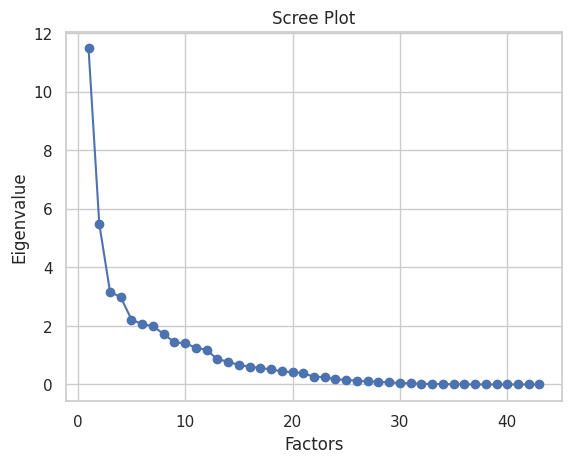

In [91]:
fa = FactorAnalyzer(50, rotation="varimax", method='ml')
fa.fit(all_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print(ev)

# scree plot using matplotlib
plt.scatter(range(1, all_df.shape[1]+1), ev)
plt.grid()

plt.plot(range(1, all_df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
# plt.show()

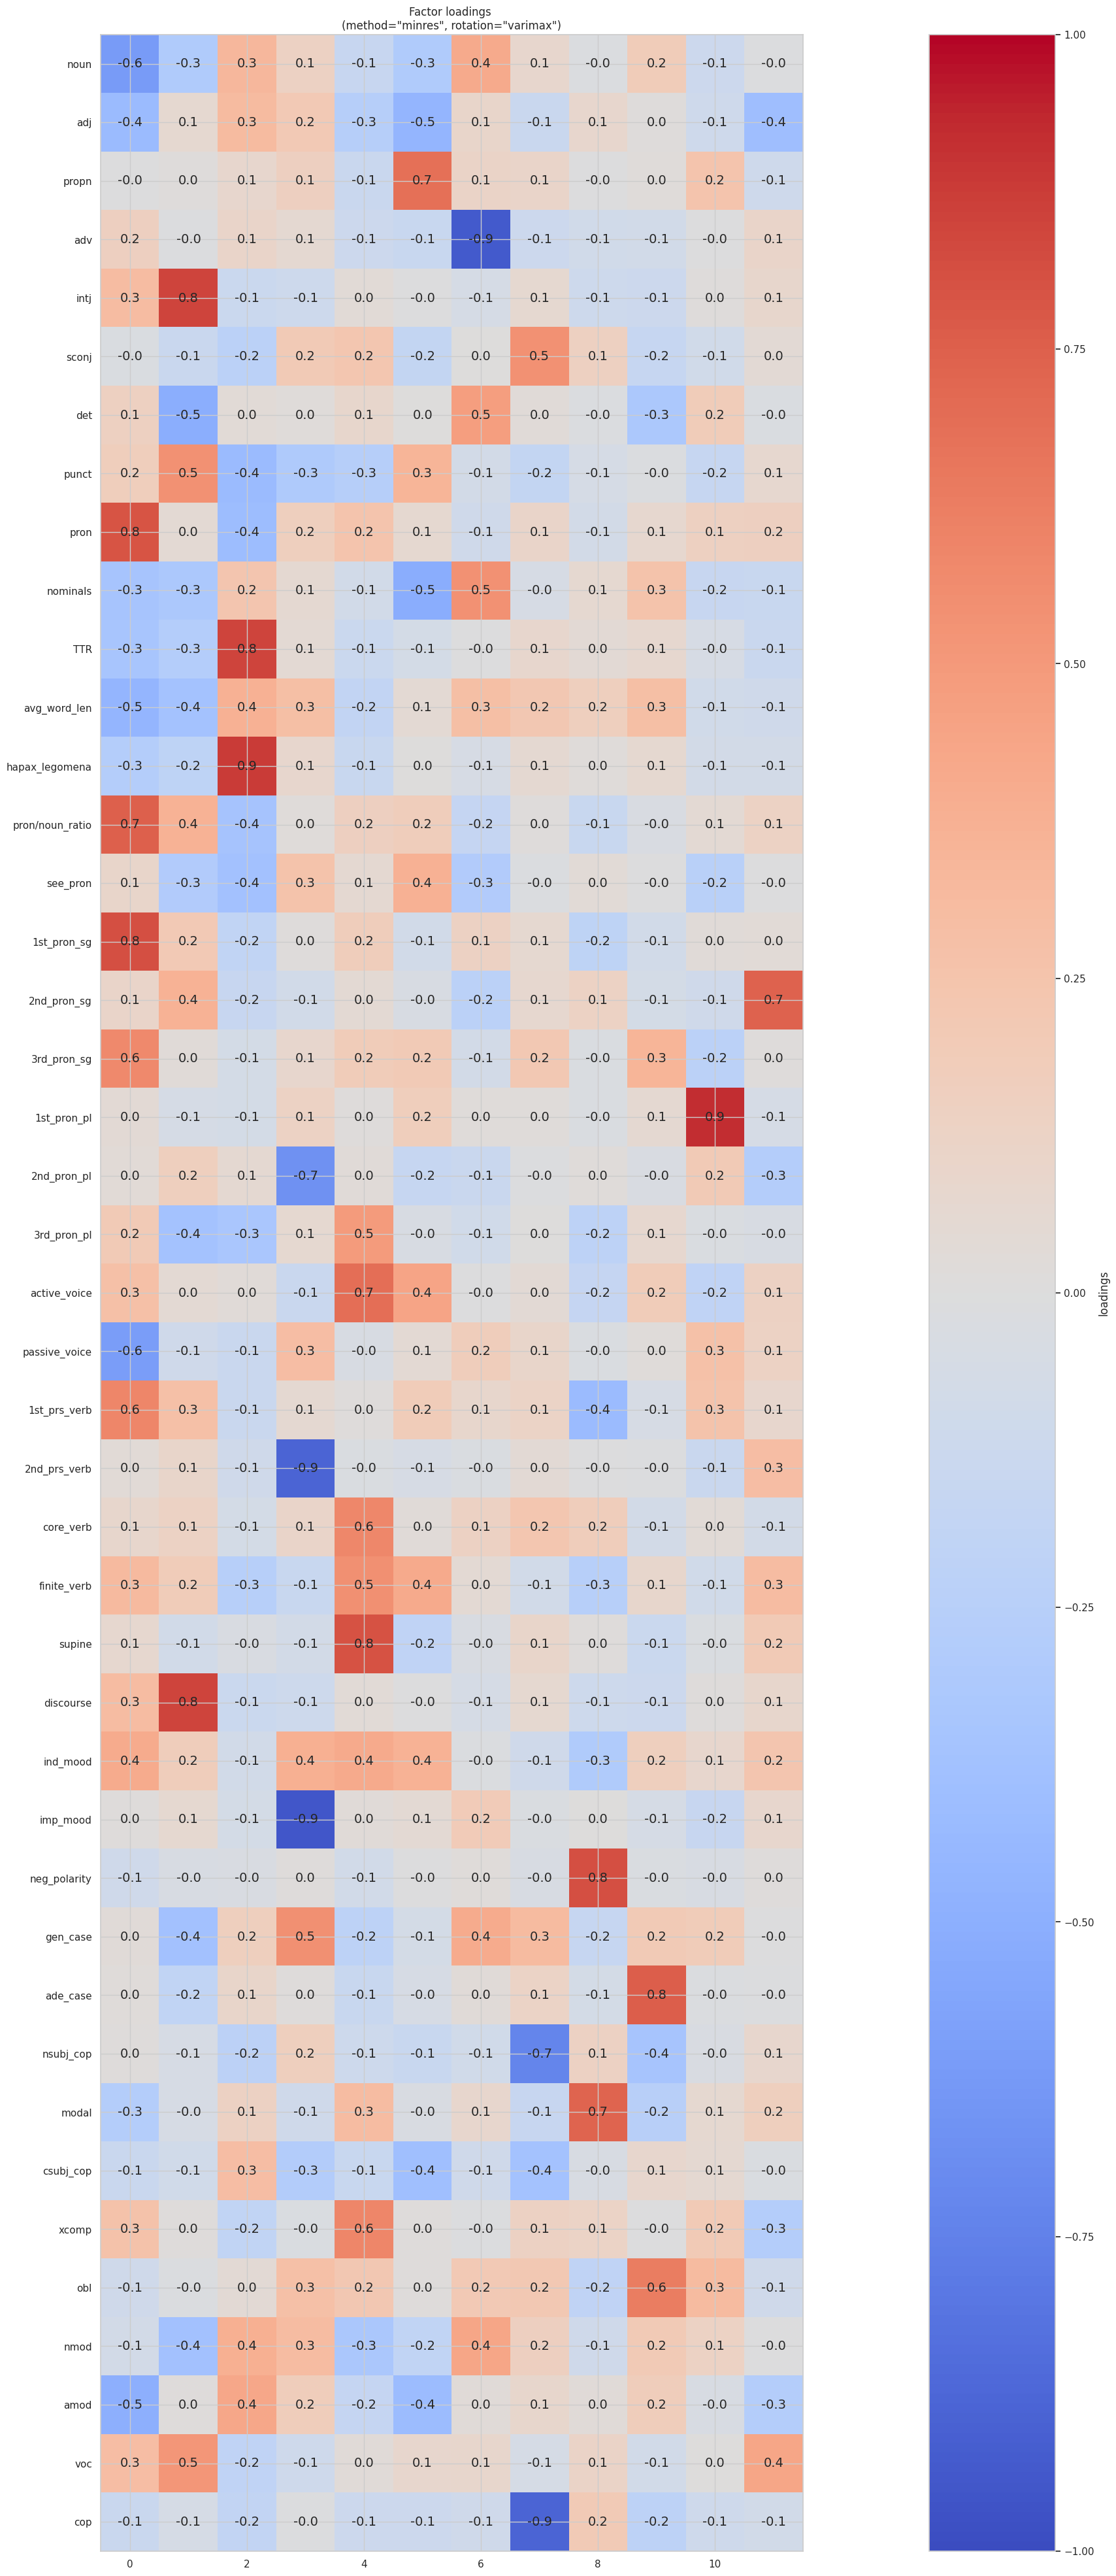

In [92]:
fa = FactorAnalyzer(12, rotation="varimax", method="minres")

fig, ax = plt.subplots(ncols=1, figsize=(50, 50), sharex=True, sharey=True)


fa = fa.fit(all_df)
factor_matrix = fa.loadings_
factor_variance = fa.get_factor_variance()
communalities = fa.get_communalities()

# for loading in factor_matrix:
#     print(loading)

# print(factor_variance)


#  Plot the data as a heat map    
im = ax.imshow(factor_matrix, cmap="coolwarm", vmax=1, vmin=-1)
#  and add the corresponding value to the center of each cell
for (i,j), z in np.ndenumerate(factor_matrix):
    ax.text(j, i, str(z.round(1)), ha="center", va="center")
#  matplotlib <- metadata of the plot
ax.set_yticks(np.arange(len(all_df.columns)))
if ax.get_subplotspec().is_first_col():
    ax.set_yticklabels(all_df.columns)
else:
    ax.set_yticklabels([])
ax.set_title(f'Factor loadings \n(method="minres", rotation="varimax")')
    
cb = fig.colorbar(im, ax=ax, location='right', label="loadings")
# plt.tight_layout()
    
#  and add a colorbar


plt.savefig('plotted_FA-12f.png')
plt.show()

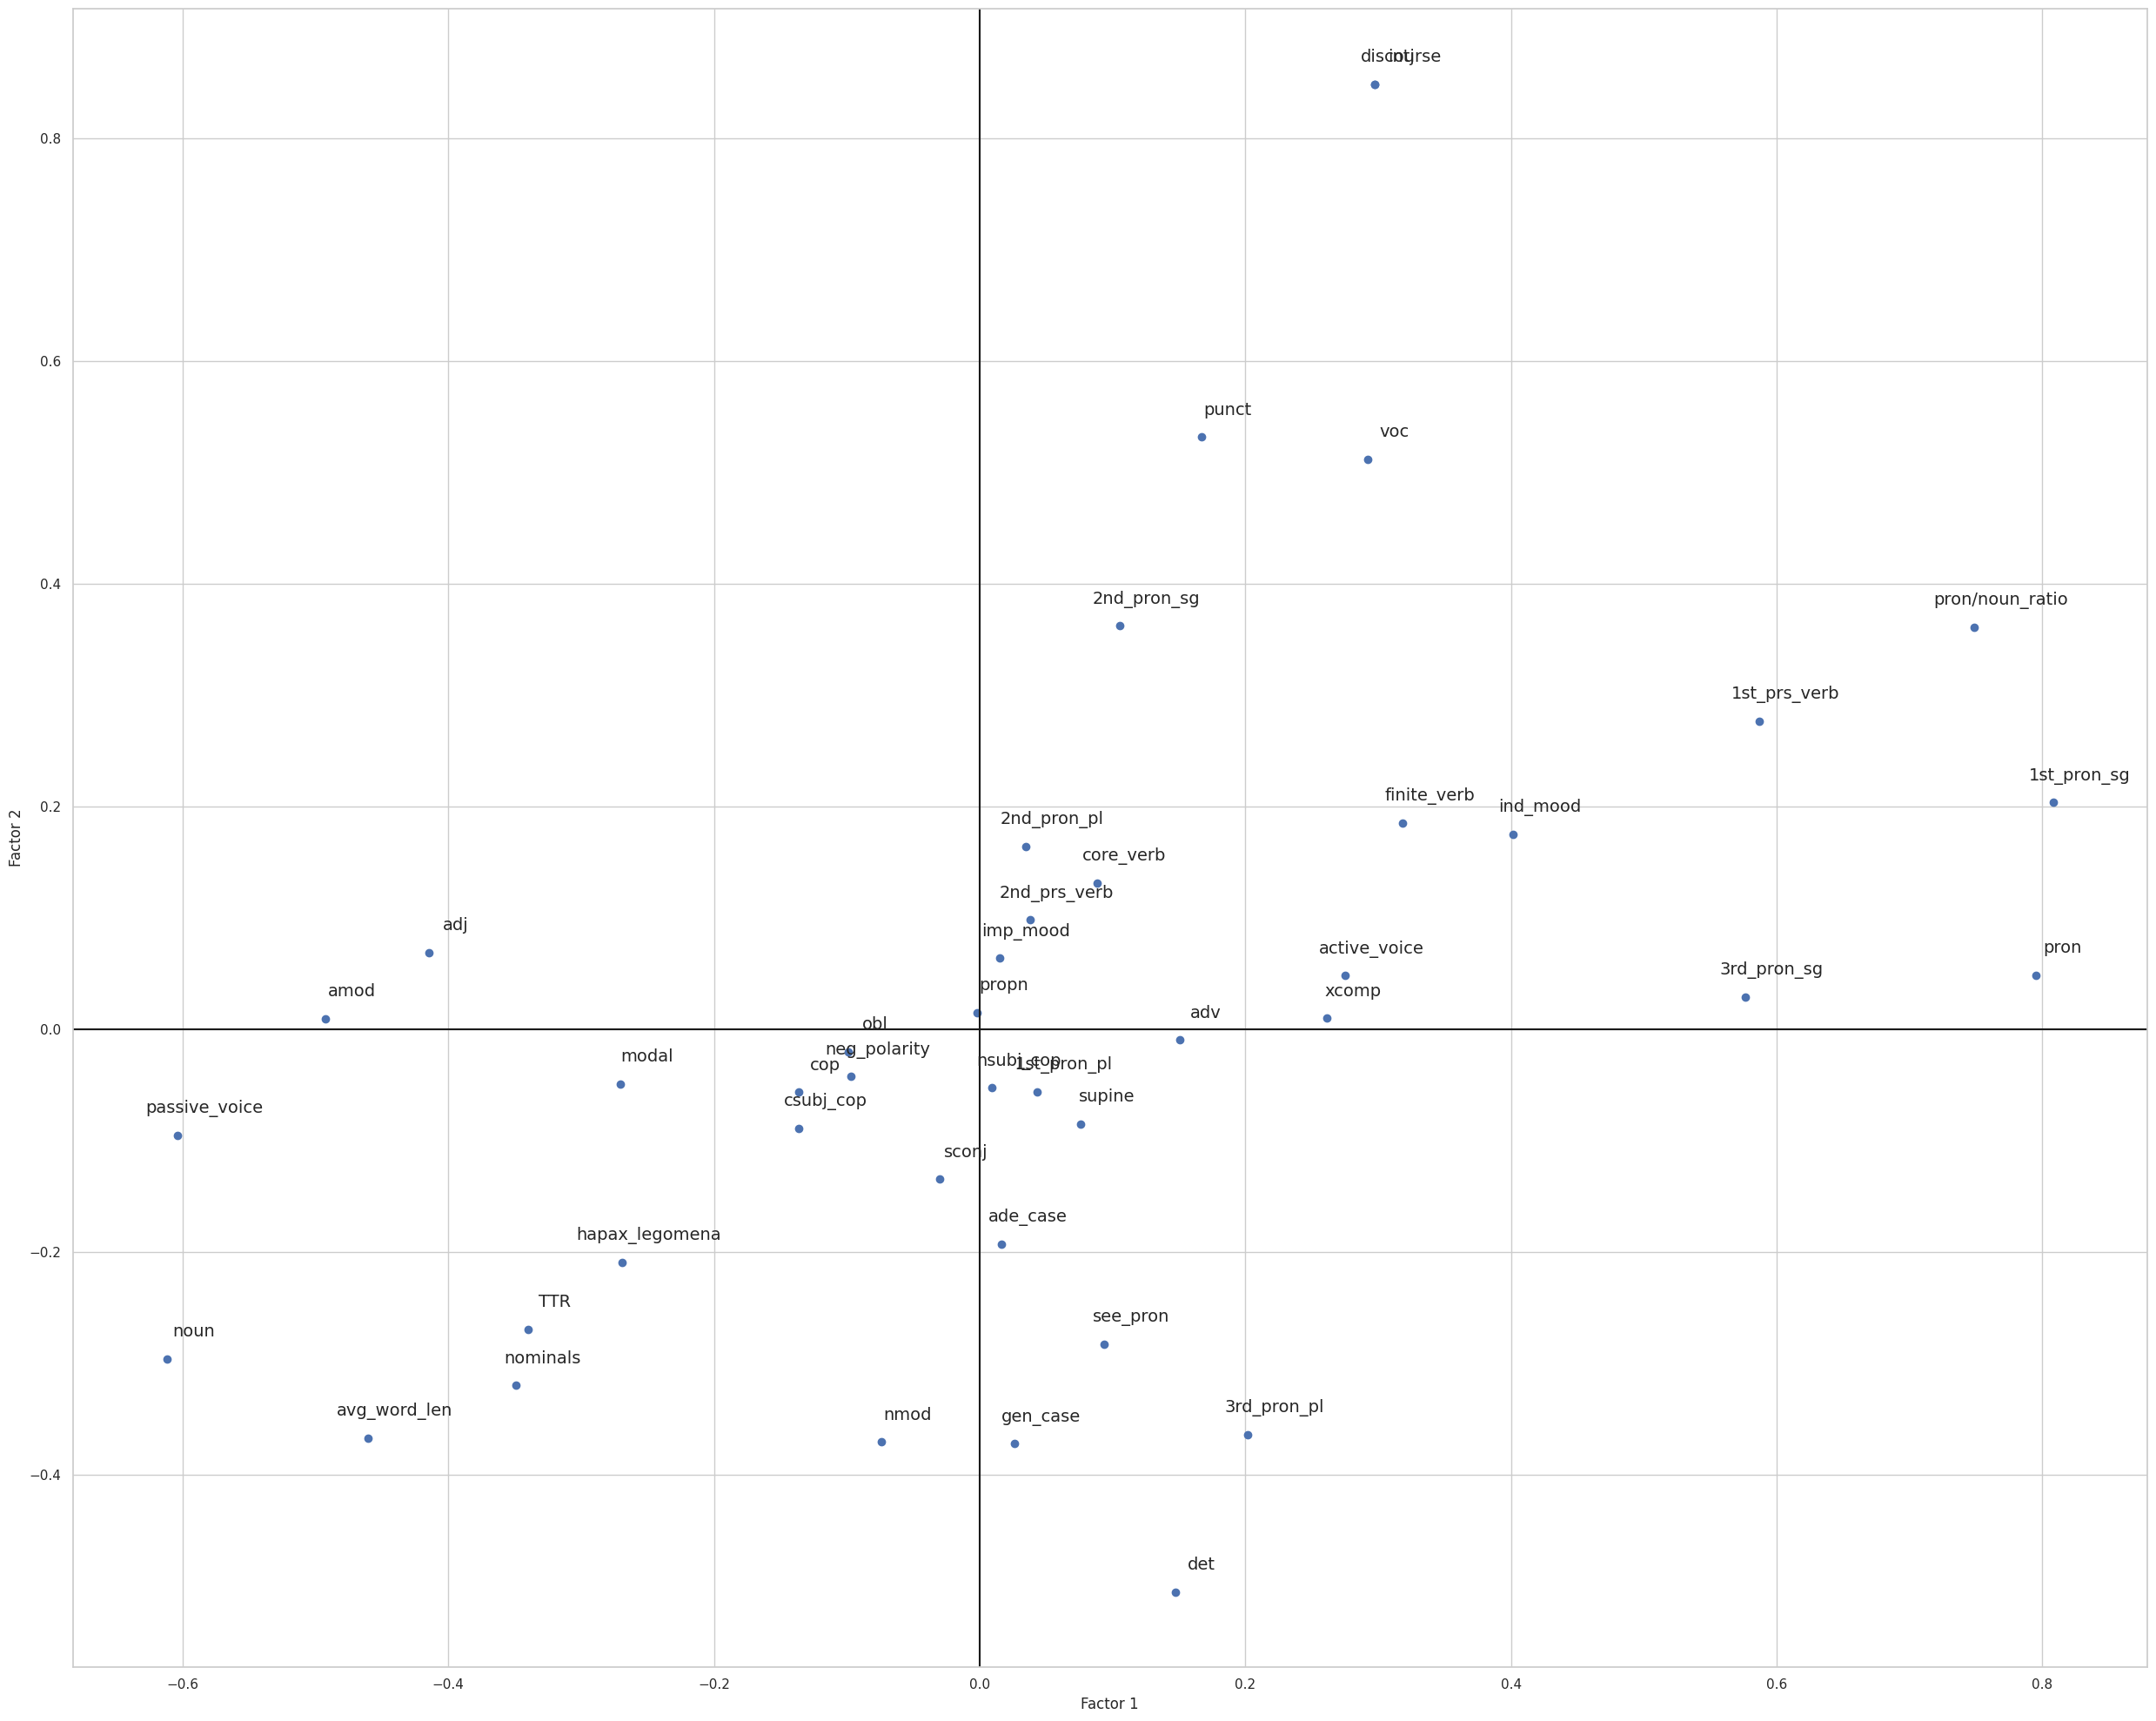

In [43]:
fig, ax = plt.subplots(ncols=1, figsize=(25,20))
components = factor_matrix.T
vmax = np.abs(components).max()
ax.scatter(components[0,:], components[1, :])
ax.axhline(0, -1, 1, color='k')
ax.axvline(0, -1, 1, color='k')
for i,j, z in zip(components[0, :], components[1, :], all_df.columns):
    ax.text(i+.02, j+.02, str(z), ha="center")
# ax.set_title(str('Varimax'))
if ax.get_subplotspec().is_first_col():
    ax.set_ylabel("Factor 2")
ax.set_xlabel("Factor 1")

plt.tight_layout()
plt.savefig('2Dplot_FA_results.png')

plt.show()

## KORRELATSIOONID DIMENSIOONIDEGA

In [ ]:
# dimensioonide vahel spearman!

f = 'limesurvey_loplikud_skoorid_koond.csv'
# f = 'limesurvey_loplikud_skoorid_ordinal.csv'

data = []
with open(f, 'r') as fid:
    csv_reader = csv.DictReader(fid, delimiter=',')
    fieldnames = csv_reader.fieldnames
    for line in csv_reader:
        data.append(line)

col_list1 = ['abs_avg1', 'info_avg1', 'aeg_avg1', 'afek_avg1', 'inter_avg1', 'inst_avg1', 'form_avg1', 'keer_avg1', 'subj_avg1', 'spont_avg1', 'imp_avg1', 'arg_avg1']
col_list2 = ['abs_avg2', 'info_avg2', 'aeg_avg2', 'afek_avg2', 'inter_avg2', 'inst_avg2', 'form_avg2', 'keer_avg2', 'subj_avg2', 'spont_avg2', 'imp_avg2', 'arg_avg2']

# mis on vahet nt abs_avg1 ja abs_avg2 vahel?  et oli kaks gruppi hindajaid. nt ühelt grupilt tuleb keskmiseks 1.5, teiselt grupilt keskmiseks 1.4, siis
# keskmine tuleb 1.45. kui aga juhtub, et ühelt grupilt saab 1 ja teise grupi hinnangut ei tea üldse (st saab ##)
# siis DIM_avg1 korral tehakse (1 + ##)2 = 1
# ja DIM_avg2 korral saab automaatselt -1 (ehk ei tea midagi selle teksti kohta)
# ja kui mõlemad grupid annavad ## ja ##, siis mõlemad saavad keskmiseks ka -1
# valituks osutus: avg1 veerg

dim_df = pd.DataFrame(data).iloc[:, 1:].astype(float)
dim_ver1 = dim_df[col_list1]
dim_ver1.columns = [col_name.split('_')[0] for col_name in dim_ver1.columns]



dim_ver1

In [ ]:
col_list = [d.split('_')[0] for d in col_list1]
dim_pairs = [pair for pair in itertools.combinations(col_list, 2)]

In [ ]:
corrs = []
for p in dim_pairs:
    arr1, arr2 = dim_ver1[p[0]], dim_ver1[p[1]]
    sp = stats.spearmanr(arr1, arr2)
#     print(p, sp)
    correlation = sp.correlation
    corrs.append([p, correlation])
corrs

In [ ]:
data = defaultdict(dict)


for dims, val in corrs:
    dim = defaultdict()
    a, b = dims[0], dims[1]
    data[a][b] = val
    data[b][a] = val
    data[a][a] = 1
    data[b][b] = 1

pd.DataFrame.from_dict(data, orient='index')

In [ ]:
from collections import defaultdict


In [ ]:
output = pd.DataFrame()
df_dictionary = pd.DataFrame([dictionary])
output = pd.concat([output, df_dictionary], ignore_index=True)
print(output.head())


In [ ]:
s

## KORRELATSIOONID TUNNUSTEGA

In [ ]:
input_f = 'limesurvey_results4.csv'

data = []

with open(input_f, 'r') as fid:
    csv_reader = csv.DictReader(fid, delimiter=',')
    fieldnames = csv_reader.fieldnames
    for line in csv_reader:
        data.append(line)

feature_df = pd.DataFrame(data).iloc[:, 1:].astype(float)
feature_df

In [ ]:
feature_names = feature_df.columns
feature_names

In [ ]:
def save_csv(prefix, df):
    df.to_csv(f'korrelatsiooni_csvd/{prefix}.csv')

In [ ]:
def plot_important_features(model, dimname):
    
    print(model.coef_)

    feature_importance = abs(model.coef_[0])
    
    
    feature_importance = 1.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(15,20))
    featax = featfig.add_subplot(1, 1, 1)

    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
    featax.set_xlabel(f'Relative Feature Importance {str.upper(dimname)}')

    # plt.tight_layout()   
    plt.show()

In [ ]:
def get_corr_pairs(corr_df):

    columns = [line for line in corr_df]
    matches = []

    for column, rows in corr_df.items():
        for m, score in rows.items():
            if (score > 0.6 or score < -0.6) and column != m:
                matches.append([(column, m), score])
            continue

    without_duplicates = []
    for ws, i in matches:
        ls = (sorted(ws), i)
        if ls not in without_duplicates:
            without_duplicates.append(ls)       

    return without_duplicates

In [ ]:
def generate_heatmap(dim, corr_data):

    my_colors = ['black', 'lightgrey', 'white', 'red']
    my_cmap = ListedColormap(my_colors)
    bounds = [-1.0, -0.6, 0.6, 1.0]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))



    mask = np.triu(np.ones_like(corr_data))

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    hmap = sns.heatmap(corr_data,
                yticklabels=1, 
                ax=ax,
                linewidths=1.0,
                cmap=my_cmap,
                norm=my_norm,
                mask=mask,
               cbar_kws = dict(use_gridspec=False,location="top")
               )

    colorbar = ax.collections[0].colorbar
    hmap.figure.savefig(f'heatmapid/{dim}_heatmap.png', format='png', dpi=150)
    plt.show()


In [ ]:

all_corr = feature_df.corr(method='spearman').round(2)

# save_csv('dimensions', all_corr)

In [ ]:
generate_heatmap('all_dims', all_corr)

In [ ]:
pairs = get_corr_pairs(all_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')